## Importing libraries and dependencies

In [1]:
!gsutil -m cp gs://dtire-special-storage/archive.zip .
!ls -l

Copying gs://dtire-special-storage/archive.zip...
| [1/1 files][707.6 MiB/707.6 MiB] 100% Done  26.4 MiB/s ETA 00:00:00           
Operation completed over 1 objects/707.6 MiB.                                    
total 724612
-rw-r--r-- 1 root root 741994332 May 20 06:02 archive.zip
drwxr-xr-x 1 root root      4096 May 17 13:39 sample_data


In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: Tire Textures/testing_data/cracked/Cracked-1.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-10.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-105.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-11.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-13.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-14.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-15.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-19.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-2.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-20.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-208.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-21.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-22.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-25.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-26.jpg  
  i

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

# Config

In [ ]:
train_path='./Tire Textures/training_data'
test_path='./Tire Textures/testing_data'
EPOCHS=10
BATCH_SIZE=32
RANDOM_SEED=42

# Data visualization

In [ ]:
labels=os.listdir(train_path)
labels

['normal', 'cracked']

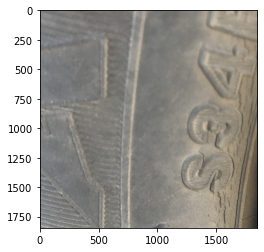

In [ ]:
train_cracked=train_path+"/cracked/"
train_normal=train_path+"/normal/"
len(os.listdir(train_cracked))
random_num=np.random.randint(0,len(os.listdir(train_cracked)))
pic_path=os.listdir(train_cracked)[random_num]

img_path=train_cracked + pic_path
plt.imshow(plt.imread(img_path))

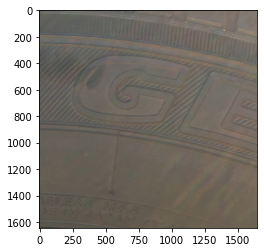

In [ ]:
train_normal=train_path+"/normal/"
len(os.listdir(train_normal))
random_num=np.random.randint(0,len(os.listdir(train_normal)))
pic_path=os.listdir(train_normal)[random_num]

img_path=train_normal + pic_path
plt.imshow(plt.imread(img_path))

# Preparing our dataset

In [ ]:
def process(data):
    path=Path(data) #get the path
    filepaths=list(path.glob(r"*/*.jpg")) # get all the subpath
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths)) #get the label for each subpath
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1) # concat the series of filepaths and label to be one dataframe
    return df

In [ ]:
df_train=process(train_path)
df_test=process(test_path)
print(df_test.shape)

df_val_test = df_test.sample(frac=1, random_state=RANDOM_SEED)
half_data_vt = int(0.5*len(df_val_test))
df_val = df_val_test.iloc[:half_data_vt,:]
df_test = df_val_test.iloc[half_data_vt:,:]
print(df_val.shape)
print(df_test.shape)


(325, 2)
(162, 2)
(163, 2)


In [ ]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)

In [ ]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=BATCH_SIZE,
                                                
                                                subset='training',
                                                random_seed=RANDOM_SEED)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    random_seed=RANDOM_SEED
)

Found 703 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.


# Model building

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False #We don't want to train again the resnet

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(2, activation='sigmoid')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training

In [ ]:
mo_fit=model.fit(train_image,epochs=EPOCHS)

Epoch 1/10
22/22 [==============================] - 147s 6s/step - loss: 0.7097 - accuracy: 0.8122
Epoch 2/10
22/22 [==============================] - 131s 6s/step - loss: 0.1846 - accuracy: 0.9403
Epoch 3/10
22/22 [==============================] - 136s 6s/step - loss: 0.1015 - accuracy: 0.9644
Epoch 4/10
22/22 [==============================] - 131s 6s/step - loss: 0.0559 - accuracy: 0.9872
Epoch 5/10
22/22 [==============================] - 130s 6s/step - loss: 0.0512 - accuracy: 0.9829
Epoch 6/10
22/22 [==============================] - 130s 6s/step - loss: 0.0673 - accuracy: 0.9744
Epoch 7/10
22/22 [==============================] - 133s 6s/step - loss: 0.0318 - accuracy: 0.9929
Epoch 8/10
22/22 [==============================] - 133s 6s/step - loss: 0.0105 - accuracy: 0.9972
Epoch 9/10
22/22 [==============================] - 129s 6s/step - loss: 0.0050 - accuracy: 1.0000
Epoch 10/10
22/22 [==============================] - 130s 6s/step - loss: 0.0023 - accuracy: 1.0000


# Performance plots

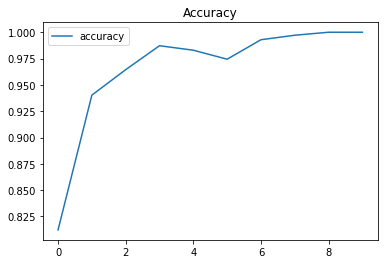

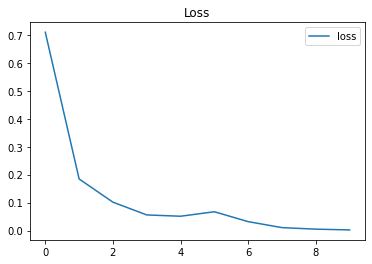

In [ ]:
pd.DataFrame(mo_fit.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(mo_fit.history)[['loss']].plot()
plt.title("Loss")
plt.show()

# Evaluation on test set

In [ ]:
model.evaluate(test_image)

11/11 [==============================] - 67s 6s/step - loss: 0.5283 - accuracy: 0.8338


[0.5282777547836304, 0.8338461518287659]